In [4]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [5]:
# Tesla stock: TSLA
company = 'Tesla'
stock_data = pd.read_csv(r"/content/drive/MyDrive/Tesla.csv", parse_dates=['Date'], sep=',', index_col='Date')

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
stock_data

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2010-06-29,19.000000,25.000000,17.540001,23.889999,18766300,23.889999
2010-06-30,25.790001,30.420000,23.299999,23.830000,17187100,23.830000
2010-07-01,25.000000,25.920000,20.270000,21.959999,8218800,21.959999
2010-07-02,23.000000,23.100000,18.709999,19.200001,5139800,19.200001
2010-07-06,20.000000,20.000000,15.830000,16.110001,6866900,16.110001
...,...,...,...,...,...,...
2017-03-13,244.820007,246.850006,242.779999,246.169998,3010700,246.169998
2017-03-14,246.110001,258.119995,246.020004,258.000000,7575500,258.000000
2017-03-15,257.000000,261.000000,254.270004,255.729996,4816600,255.729996


Text(0.5, 1.0, 'Tesla stock closing price')

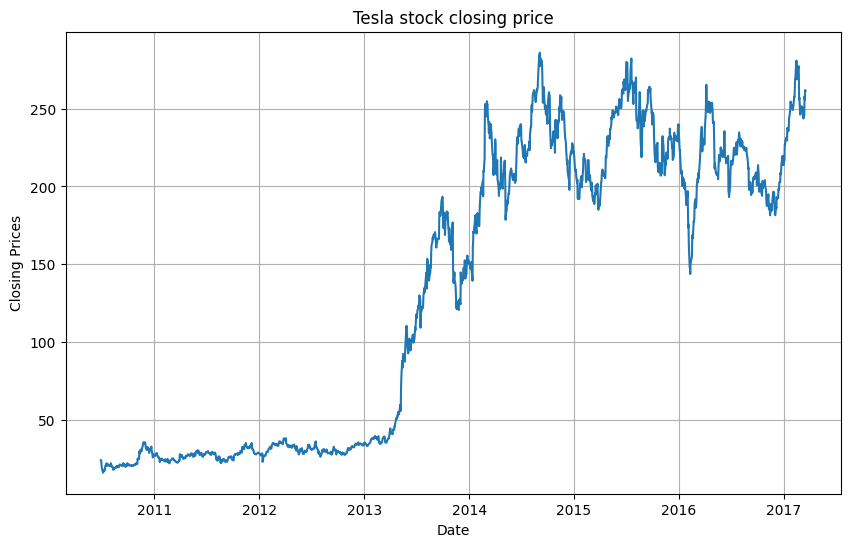

In [8]:
# Plot closing prices
df_close = stock_data['Close']

plt.figure(figsize=(10,6))
plt.grid()
plt.plot(df_close)
plt.xlabel('Date')
plt.ylabel('Closing Prices')
plt.title('Tesla stock closing price')

In [9]:
def test_stationarity(timeseries):
    '''
    Input: timeseries (dataframe): timeseries for which we want to study the stationarity
    '''

    #Determing rolling statistics
    rolmean = timeseries.rolling(20).mean()
    rolstd = timeseries.rolling(20).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value',\
                                             '#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

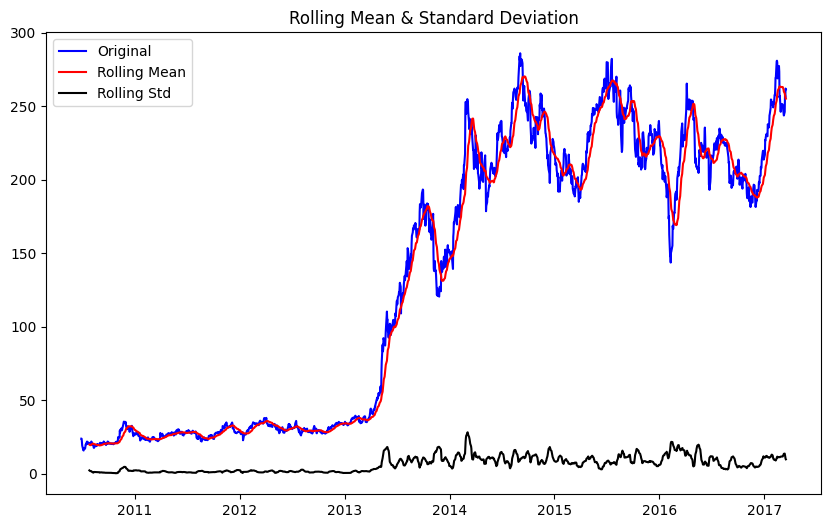

Results of Dickey-Fuller Test:
Test Statistic                   -0.813733
p-value                           0.815055
#Lags Used                        0.000000
Number of Observations Used    1691.000000
Critical Value (1%)              -3.434223
Critical Value (5%)              -2.863251
Critical Value (10%)             -2.567681
dtype: float64


In [10]:
plt.figure(figsize = (10,6))
test_stationarity(df_close.head(2000))

<Figure size 640x480 with 0 Axes>

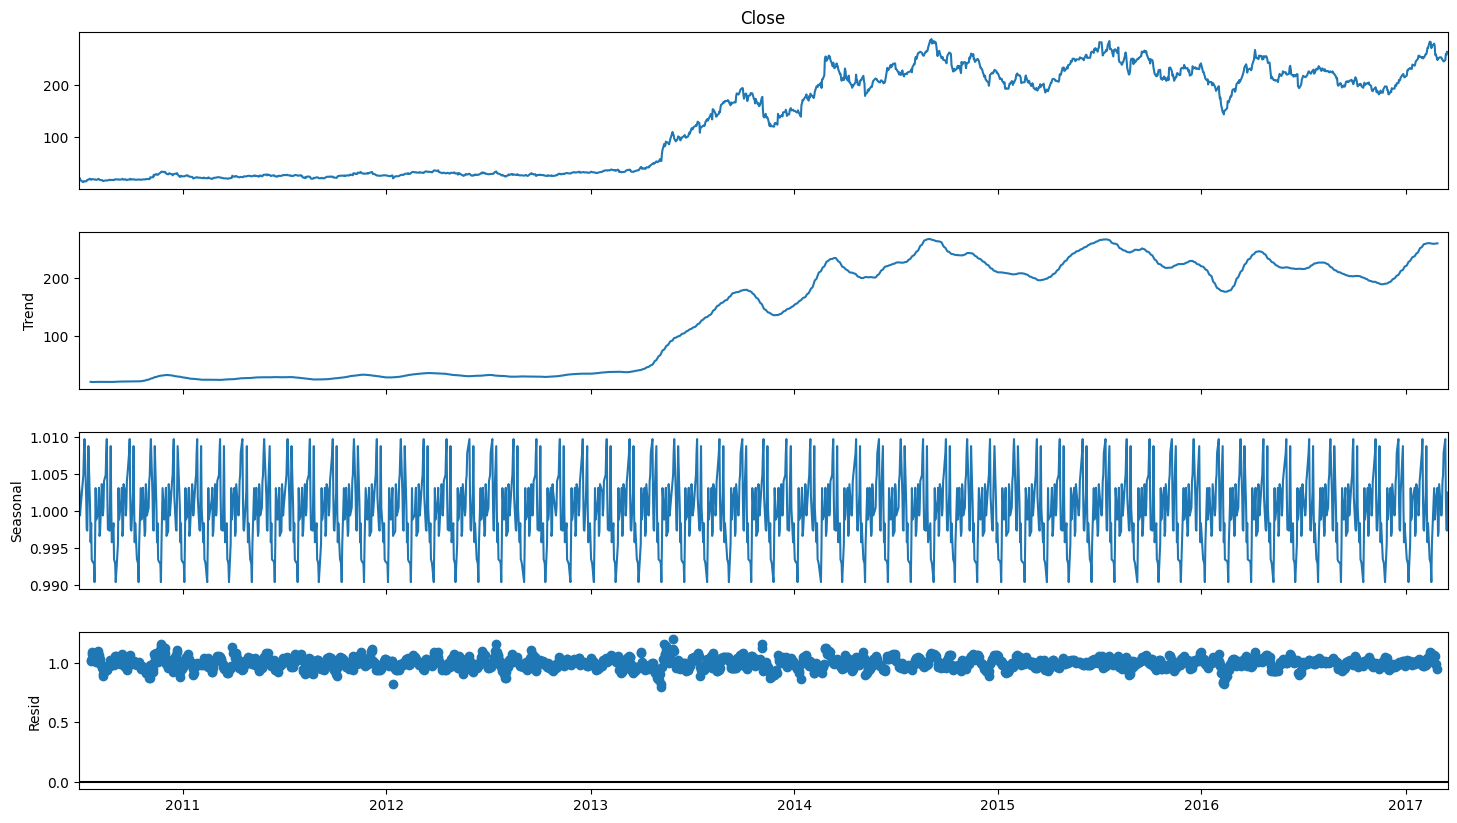

In [11]:

result = seasonal_decompose(df_close, model='multiplicative',period=28)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)

Text(0.5, 1.0, 'Transformed data')

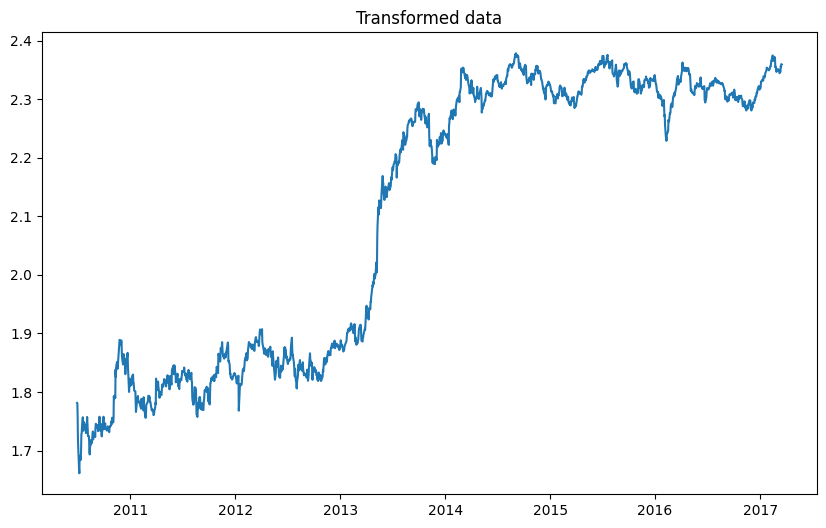

In [12]:
df_close_log = df_close.apply(np.log)
df_close_tf = df_close_log.apply(np.sqrt)

plt.figure(figsize = (10,6))
plt.plot(df_close_tf)
plt.title('Transformed data')

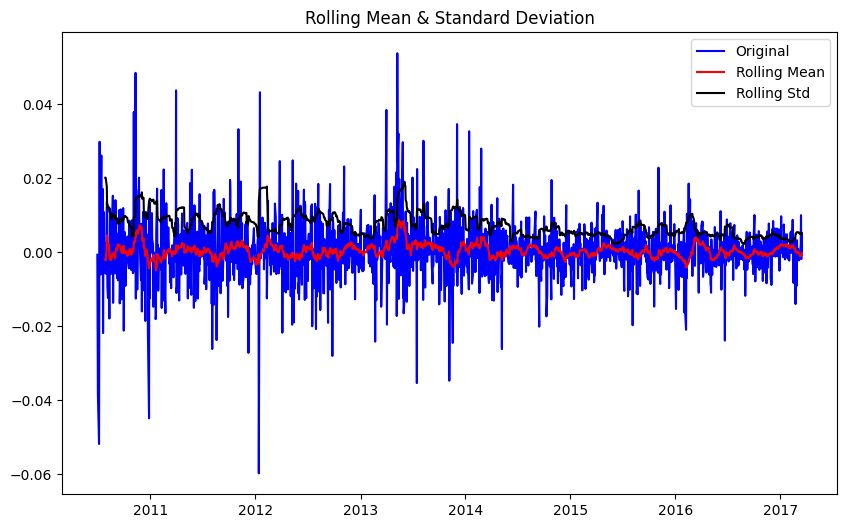

Results of Dickey-Fuller Test:
Test Statistic                  -30.121227
p-value                           0.000000
#Lags Used                        1.000000
Number of Observations Used    1689.000000
Critical Value (1%)              -3.434228
Critical Value (5%)              -2.863253
Critical Value (10%)             -2.567682
dtype: float64


In [13]:
df_close_shift = df_close_tf - df_close_tf.shift()

df_close_shift.dropna(inplace=True)
plt.figure(figsize = (10,6))
test_stationarity(df_close_shift)

In [14]:
def preprocess_lstm(sequence, n_steps,n_features):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix >= len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)

    X = np.array(X)
    y = np.array(y)

    X = X.reshape((X.shape[0], X.shape[1], n_features))
    return X, y

In [15]:
# choose the number of days on which to base our predictions
nb_days = 60

n_features = 1

X, y = preprocess_lstm(df_close_shift.to_numpy(), nb_days, n_features)

In [16]:
#Split the data set between the training set and the test set
test_days = 365

X_train, y_train = X[:-test_days], y[:-test_days]
X_test, y_test = X[-test_days:], y[-test_days:]

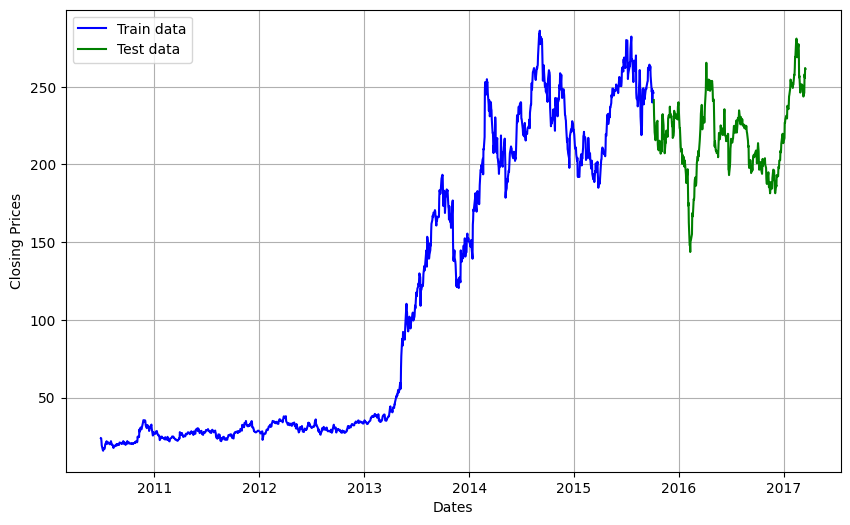

In [17]:
train_original = df_close.iloc[:-test_days]
test_original = df_close.iloc[-test_days:]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_original, 'b', label='Train data')
plt.plot(test_original, 'g', label='Test data')
plt.legend()

In [18]:
def vanilla_LSTM():
    model = Sequential()
    model.add(LSTM(units=50, input_shape=(nb_days, n_features)))
    model.add(Dense(1))
    return model

In [19]:
model = vanilla_LSTM()
model.summary()
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.fit(X_train,
          y_train,
          epochs=15,
          batch_size = 32)

Epoch 1/15
40/40 [==============================] - 9s 6ms/step - loss: 8.7317e-05 - mean_absolute_error: 0.0069
Epoch 2/15
40/40 [==============================] - 0s 6ms/step - loss: 7.3259e-05 - mean_absolute_error: 0.0058
Epoch 3/15
40/40 [==============================] - 0s 5ms/step - loss: 7.3658e-05 - mean_absolute_error: 0.0059
Epoch 4/15
40/40 [==============================] - 0s 5ms/step - loss: 7.3163e-05 - mean_absolute_error: 0.0058
Epoch 5/15
40/40 [==============================] - 0s 5ms/step - loss: 7.5846e-05 - mean_absolute_error: 0.0060
Epoch 6/15
40/40 [==============================] - 0s 5ms/step - loss: 7.3067e-05 - mean_absolute_error: 0.0058
Epoch 7/15
40/40 [==============================] - 0s 5ms/step - loss: 7.3878e-05 - mean_absolute_error: 0.0059
Epoch 8/15
40/40 [==============================] - 0s 6ms/step - loss: 7.3495e-05 - mean_absolute_error: 0.0058
Epoch 9/15
40/40 [==============================] - 0s 5ms/step - loss: 7.2970e-05 - mean_absolu

In [21]:
# Evaluate the model on the test data using
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=32)
print("Test MSE:", results[0])
print("Test MAE:", results[1])

Evaluate on test data
12/12 [==============================] - 1s 5ms/step - loss: 2.9819e-05 - mean_absolute_error: 0.0040
Test MSE: 2.981872057716828e-05
Test MAE: 0.003976213745772839


12/12 [==============================] - 1s 3ms/step


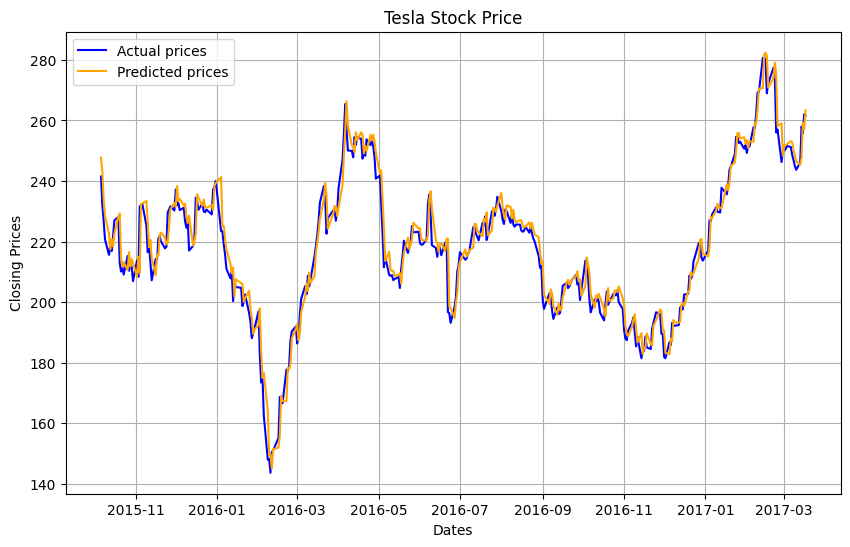

In [22]:
# Prediction
y_pred = model.predict(X_test)

# We create a dataframe from y_pred to have date-time indexes.
pred_data = pd.DataFrame(y_pred[:,0], test_original.index,columns=['Close'])

# Apply inverse transformation from 1.d

# Add the differenciation term
pred_data['Close'] = pred_data['Close'] + df_close_tf.shift().values[-test_days:]

# Take the square, and the exponent
pred_data = pred_data.apply(np.square)
pred_data = pred_data.apply(np.exp)


# Plot actual prices vs predicted prices
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(test_original,'b',label='Actual prices')
plt.plot(pred_data, 'orange',label='Predicted prices')
plt.title(company + ' Stock Price')

plt.legend()

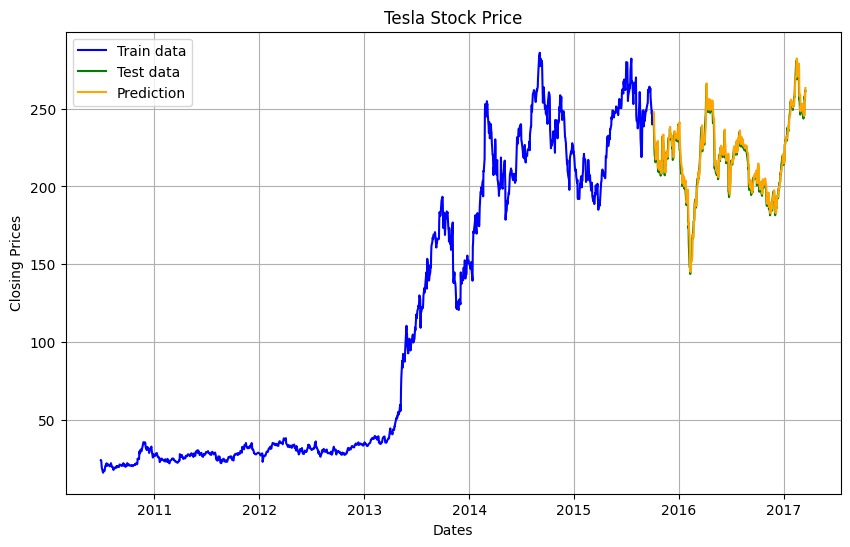

In [23]:

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_original, 'b', label='Train data')
plt.plot(test_original, 'g', label='Test data')
plt.plot(pred_data, 'orange', label='Prediction')
plt.title(company + ' Stock Price')
plt.legend()

In [24]:
def preprocess_multistep_lstm(sequence, n_steps_in, n_steps_out, features):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)

    X = np.array(X)
    y = np.array(y)

    X = X.reshape((X.shape[0], X.shape[1], n_features))

    return X, y

In [25]:
# Number of days into the future we want to predict
n_steps_out = 10

# choose the number of days on which to base our predictions
nb_days = 60

n_features = 1

X, y = preprocess_multistep_lstm(df_close_shift.to_numpy(), nb_days, n_steps_out, n_features)


In [26]:
#Split the data set between the training set and the test set
test_days = 365

X_train, y_train = X[:-test_days], y[:-test_days]
X_test, y_test = X[-test_days:], y[-test_days:]

In [27]:
def vanilla_multistep_LSTM():
    model = Sequential()
    model.add(LSTM(units=50, input_shape=(nb_days, n_features)))
    model.add(Dense(n_steps_out))
    return model

In [28]:
model = vanilla_multistep_LSTM()
model.summary()
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                10400     
                                                                 
 dense_1 (Dense)             (None, 10)                510       
                                                                 
Total params: 10,910
Trainable params: 10,910
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.fit(X_train,
          y_train,
          epochs=15,
          batch_size = 32)

Epoch 1/15
40/40 [==============================] - 3s 6ms/step - loss: 7.6348e-05 - mean_absolute_error: 0.0060
Epoch 2/15
40/40 [==============================] - 0s 5ms/step - loss: 7.5504e-05 - mean_absolute_error: 0.0060
Epoch 3/15
40/40 [==============================] - 0s 6ms/step - loss: 7.4617e-05 - mean_absolute_error: 0.0059
Epoch 4/15
40/40 [==============================] - 0s 6ms/step - loss: 7.4874e-05 - mean_absolute_error: 0.0059
Epoch 5/15
40/40 [==============================] - 0s 5ms/step - loss: 7.3659e-05 - mean_absolute_error: 0.0059
Epoch 6/15
40/40 [==============================] - 0s 6ms/step - loss: 7.4074e-05 - mean_absolute_error: 0.0059
Epoch 7/15
40/40 [==============================] - 0s 6ms/step - loss: 7.3543e-05 - mean_absolute_error: 0.0059
Epoch 8/15
40/40 [==============================] - 0s 5ms/step - loss: 7.4113e-05 - mean_absolute_error: 0.0059
Epoch 9/15
40/40 [==============================] - 0s 6ms/step - loss: 7.3770e-05 - mean_absolu

In [30]:
# Evaluate the model on the test set
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=32)

print("Test MSE:", results[0])
print("Test MAE:", results[1])

Evaluate on test data
12/12 [==============================] - 0s 3ms/step - loss: 2.9091e-05 - mean_absolute_error: 0.0039
Test MSE: 2.9090635507600382e-05
Test MAE: 0.00392542127519846


12/12 [==============================] - 0s 2ms/step


Text(0.5, 1.0, 'Original data vs predictions in the transformed space')

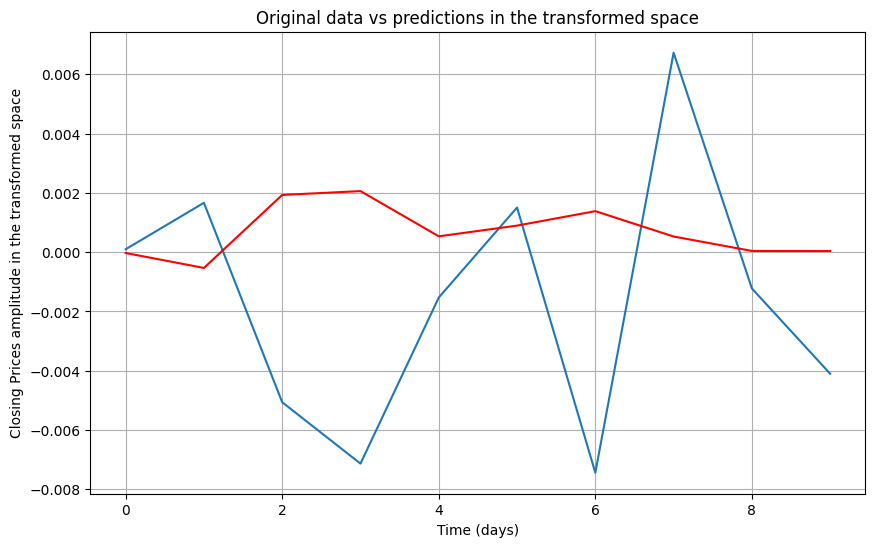

In [31]:
# Prediction
y_pred = model.predict(X_test)

# the_day is the day from which we will study the n_steps_out-th dayS of prediction into
# the future. Note: The first day start at index 0
the_day = 0
y_pred_days = y_pred[the_day,:]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(y_test[the_day,:],label='Orginal data - transformed')
plt.plot(y_pred_days, color='red',label='Predictions - transformed')
plt.xlabel('Time (days)')
plt.ylabel('Closing Prices amplitude in the transformed space')
plt.title('Original data vs predictions in the transformed space')

In [32]:
# Apply inverse transformations from 3.a

# Add the differenciation term
pred_diff_cumsum = y_pred_days.cumsum()

base_number = df_close_tf.values[-test_days+the_day+nb_days-1]
idx = test_original.iloc[the_day:the_day+n_steps_out].index

pred_tf = pd.Series(base_number, index=idx)
pred_tf = pred_tf.add(pred_diff_cumsum,fill_value=0)

print(pred_tf)

Date
2015-10-06    2.339341
2015-10-07    2.338809
2015-10-08    2.340739
2015-10-09    2.342799
2015-10-12    2.343334
2015-10-13    2.344230
2015-10-14    2.345614
2015-10-15    2.346141
2015-10-16    2.346182
2015-10-19    2.346220
dtype: float64


In [33]:
# Take the square, and the exponent
pred_log = pred_tf.apply(np.square)
pred = pred_log.apply(np.exp)
print(pred)

Date
2015-10-06    238.058968
2015-10-07    237.466237
2015-10-08    239.621377
2015-10-09    241.944535
2015-10-12    242.551133
2015-10-13    243.572286
2015-10-14    245.158028
2015-10-15    245.765711
2015-10-16    245.812565
2015-10-19    245.856243
dtype: float64


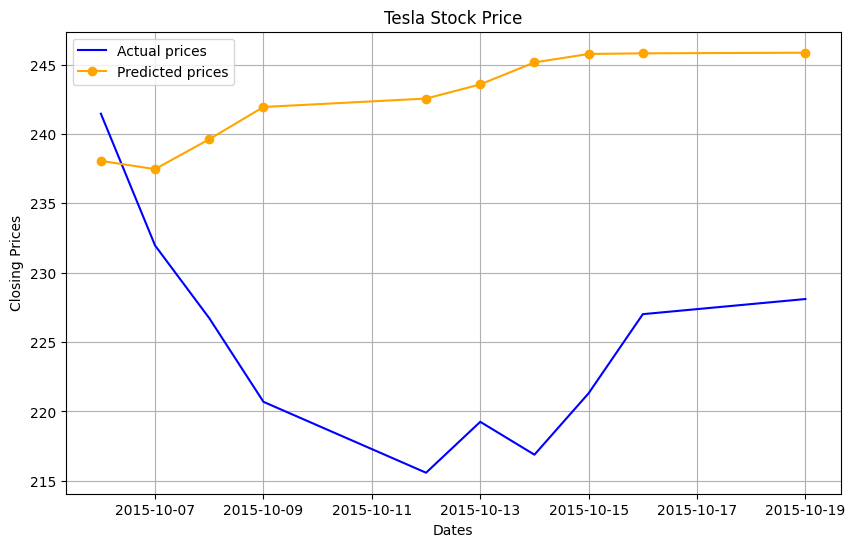

In [34]:
# Plot actual prices vs predicted prices
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(test_original.iloc[max(0,the_day-30):the_day+n_steps_out],'b',label='Actual prices')
plt.plot(pred, '-o',color='orange',label='Predicted prices')
plt.title(company + ' Stock Price')

plt.legend()